# Random Forest

In [1]:
import some_load_train_evaluate_functions as ml

from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '../KG/db.env'

driver = ml.connect_to_neo4j(path)

Connected to database successfully.


### Load Data

In [3]:
# Diabetes data

diabetes_df = ml.get_data_of_disease(driver, 'Diabetes')
diabetes_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Diabetes
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,1
8889,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8890,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8891,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


### Training

In [3]:
random_forest = RandomForestClassifier(random_state=42)

# Attributes and Labels

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

# Training

random_forest.fit(X_train, y_train)

# Accuracy scores

y_pred = random_forest.predict(X_val)

print('Training Accuracy: ',ml.accuracy_score(y_train, random_forest.predict(X_train)))

print('Validation Accuracy: ',ml.accuracy_score(y_val, y_pred))

Training Accuracy:  0.9955018273826258
Validation Accuracy:  0.9960640989597975


## Feature Selection

### Correlation Analysis

In [4]:
pos_corr, neg_corr = ml.get_correlated_features(diabetes_df,'Diabetes',pos=0.1,neg=-0.1)

corr_features = ['Gender'] + list(pos_corr.keys()[1:10]) + list(neg_corr.keys()[:10])
corr_features

['Gender',
 'Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Triglyceride [mmol/L]',
 'Total Lycopene [umol/L]',
 'Trans-lycopene [umol/L]',
 'Platelet count [1000 cells/uL]',
 'A/G Ratio',
 'Chloride [mmol/L]',
 'Platelet_WBC Ratio',
 'Direct HDL-Cholesterol [mmol/L]',
 'Albumin [g/dL]',
 'Alpha-crypotoxanthin [umol/L]',
 'Lymphocyte_C-Reactive Protein Ratio']

In [5]:
ml.evaluate_feature_set(corr_features, RandomForestClassifier(random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)


Train Accuracy: 0.996

Test Accuracy: 0.996

Precision: 0.996

Recall: 0.975

F1-Score: 0.985


### SelectFromModel

In [6]:
sfm_features = ml.select_from_model_features(RandomForestClassifier(random_state=42, n_jobs=-1),X,y)
sfm_features

['Age',
 'BMI',
 'Chromium [nmol/L]',
 'Cobalt [nmol/L]',
 'Glycohemoglobin [%]',
 'Blood Urea Nitrogen [mg/dL]',
 'Osmolality [mmol/Kg]',
 'Fasting Glucose [mmol/L]']

In [7]:
sfm_features = list(sfm_features)

ml.evaluate_feature_set(sfm_features, RandomForestClassifier(random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)


Train Accuracy: 0.994

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### SelectKBest

In [8]:
k_best_features = ml.select_k_best(X, y, n=30)
k_best_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Lymphocyte [%]',
 'Insulin [pmol/L]',
 'Alpha-tocopherol [umol/L]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Segmented neutrophils [%]',
 'Neutrophil_Lymphocyte Ratio',
 'Alpha-crypotoxanthin [umol/L]',
 'Albumin [g/dL]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Platelet_WBC Ratio',
 'C-Reactive Protein [mg/L]',
 'Creatinine [mg/dL]',
 'Ferritin [ng/mL]',
 'Chloride [mmol/L]',
 'Red cell distribution width [%]',
 'Triglyceride [mmol/L]',
 'A/G Ratio',
 'Platelet count [1000 cells/uL]',
 'Triglyceride_HDL Ratio',
 'Trans-lycopene [umol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Total Lycopene [umol/L]',
 'Mean platelet volume [fL]']

In [9]:
ml.evaluate_feature_set(k_best_features[:30], RandomForestClassifier(random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Recursive Feature Elimination (RFE) 

In [10]:
rfe_features = ml.select_rfe_features(RandomForestClassifier(random_state=42, n_jobs=-1),X,y,n=30,step=0.5)
rfe_features[:30]

['Direct HDL-Cholesterol [mmol/L]',
 'Mean cell volume [fL]',
 'Retinol [umol/L]',
 'Platelet count [1000 cells/uL]',
 'C-Reactive Protein [mg/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Chloride [mmol/L]',
 'Gamma-tocopherol [umol/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Creatine Phosphokinase [IU/L]',
 'Trans-beta-carotene [umol/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Insulin [pmol/L]',
 'Creatinine [mg/dL]',
 'A/G Ratio',
 'Transferrin receptor [nmol/L]',
 'Non_HDL Ratio',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Lactate Dehydrogenase [IU/L]',
 'Osmolality [mmol/Kg]',
 'Age',
 'Monocyte [%]',
 'Glycohemoglobin [%]',
 'Lymphocyte [%]',
 'Fasting Glucose [mmol/L]',
 'BMI',
 'Total Cholesterol [mmol/L]',
 'Ferritin [ng/mL]',
 'Cobalt [nmol/L]',
 'Chromium [nmol/L]']

In [11]:
ml.evaluate_feature_set(rfe_features[:30], RandomForestClassifier(random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Lasso Regularization

In [12]:
l1_selected_features = ml.log_reg_lasso_select(X_train, y_train)
l1_selected_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'Gender',
 'BMI',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'Non_HDL Ratio',
 'Alkaline Phosphatase [IU/L]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Vitamin C [umol/L]',
 'Blood lead [umol/L]',
 'Transferrin receptor [nmol/L]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Aspartate Aminotransferase [U/L]',
 'Transferrin Saturation [%]',
 'Creatine Phosphokinase [IU/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Creatinine [mg/dL]',
 'White blood cell count [1000 cells/uL]',
 'Platelet_Lymphocyte Ratio',
 'Total Cholestrol_HDL Ratio',
 'Retinyl palmitate [umol/L]',
 'Uric Acid [mg/dL]',
 'Bicarbonate [mmol/L]',
 'Sodium [mmol/L]',
 'Direct HDL-Cholesterol [mmol/L]']

In [13]:
ml.evaluate_feature_set(l1_selected_features[:30], RandomForestClassifier(random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)


Train Accuracy: 0.996

Test Accuracy: 0.996

Precision: 0.996

Recall: 0.975

F1-Score: 0.985


### Relief F

In [14]:
relieff_features = ml.relief_feature_select(30,X,y)

In [15]:
relieff_features[:30]

['Age',
 'Glycohemoglobin [%]',
 'BMI',
 'Segmented neutrophils [%]',
 'Hematocrit [%]',
 'Lymphocyte [%]',
 'Hemoglobin [g/dL]',
 'Fasting Glucose [mmol/L]',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'Non_HDL Ratio',
 'Neutrophil_Lymphocyte Ratio',
 'Alpha-tocopherol [umol/L]',
 'Osmolality [mmol/Kg]',
 'Mean cell volume [fL]',
 'Sodium [mmol/L]',
 'Total Cholestrol_HDL Ratio',
 'Total Iron Binding Capacity [umol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Chloride [mmol/L]',
 'Mean cell hemoglobin [pg]',
 'RBC count [million cells/uL]',
 'Total Protein [g/dL]',
 'Total Calcium [mg/dL]',
 'A/G Ratio',
 'Potassium [mmol/L]',
 'Uric Acid [mg/dL]',
 'Lactate Dehydrogenase [IU/L]',
 'Transferrin Saturation [%]',
 'Mean platelet volume [fL]']

In [16]:
ml.evaluate_feature_set(relieff_features[:30], RandomForestClassifier(random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Random Forest Feature Importances

In [17]:
def get_rand_forest_features(model, X_train):
    random_forest_features = ml.pd.DataFrame(model.feature_importances_, index=X_train.columns,
                                             columns=['Importance'])
    random_forest_features = random_forest_features.sort_values('Importance', ascending=False)
    random_forest_features = list(random_forest_features.index)
    
    return random_forest_features

In [18]:
random_forest_features = get_rand_forest_features(random_forest, X_train)
random_forest_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Cobalt [nmol/L]',
 'Chromium [nmol/L]',
 'Osmolality [mmol/Kg]',
 'Total Cholesterol [mmol/L]',
 'Creatinine [mg/dL]',
 'Retinol [umol/L]',
 'Insulin [pmol/L]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'C-Reactive Protein [mg/L]',
 'Triglyceride_HDL Ratio',
 'Alpha-crypotoxanthin [umol/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Non_HDL Ratio',
 'Direct HDL-Cholesterol [mmol/L]',
 'Chloride [mmol/L]',
 'Transferrin receptor [nmol/L]',
 'RBC count [million cells/uL]',
 'Gamma-tocopherol [umol/L]',
 'Mean cell volume [fL]',
 'Platelet count [1000 cells/uL]',
 'Hematocrit [%]',
 'Iron frozen [umol/L]',
 'Uric Acid [mg/dL]',
 'Trans-lycopene [umol/L]',
 'Lactate Dehydrogenase [IU/L]']

In [19]:
ml.evaluate_feature_set(random_forest_features, RandomForestClassifier(random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)


Train Accuracy: 0.996

Test Accuracy: 0.996

Precision: 0.996

Recall: 0.973

F1-Score: 0.984


### Optimal no. of features

In [20]:
final_features = list(random_forest_features) 

Finding optimal no. of features..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [08:32<00:00,  6.03s/it]



Maximum f1 = 0.7380 for 38 features


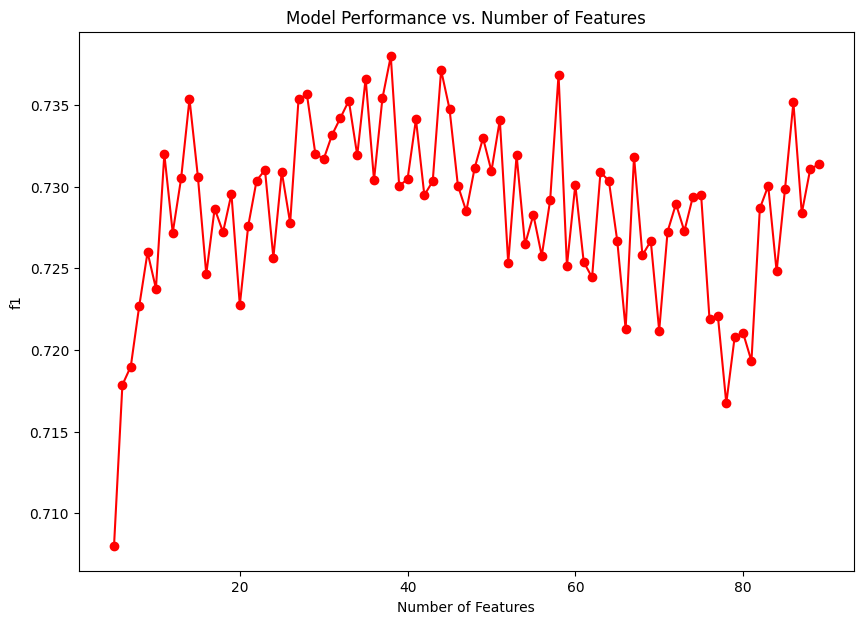

In [21]:
# Optimal no. of features

ml.plot_num_feature_performance(RandomForestClassifier(random_state=42, n_jobs=-1),  X_train, y_train, 
                                final_features, scoring='f1')

In [22]:
num_features = 38

selected = final_features[:num_features]
selected.append('Diabetes')

diabetes_df = diabetes_df[selected]

In [23]:
# Save feature set
    
with open('../Models/Diabetes/Feature Sets/Random Forest Features.pkl', 'wb') as f:
    ml.pickle.dump(selected, f)

## Preprocessing

### Zero Imputation

In [24]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                        impute = True, scale=True,
                                                        imputer=ml.SimpleImputer(strategy='constant',fill_value=0),
                                                        random_state=42)

In [25]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Mode Imputation

In [26]:
# Imputing with most frequent values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)

In [27]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### k-NN Imputation

In [28]:
# Imputing missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.KNNImputer(n_neighbors=20),
                                                              random_state=42)

In [29]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.997

Test Accuracy: 0.994

Precision: 0.989

Recall: 0.967

F1-Score: 0.978


### Multiple Imputation by Chained Equations (MICE)

In [30]:
# Imputes by looking at data from other columns and trying to estimate the best prediction for each missing value.

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.IterativeImputer(max_iter=20),
                                                              random_state=42)

In [31]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.987

Recall: 0.975

F1-Score: 0.981


### Median Imputation

In [32]:
# Imputing with median values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='median'),
                                                              random_state=42)

In [33]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Dropping Null Values

In [34]:
# Drop null values
diabetes_df_na = diabetes_df.dropna()

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df_na, label = 'Diabetes',
                                                              impute = False, scale=True,
                                                              random_state=42)

In [35]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### Mean Imputation

In [36]:
# Splitting and Preprocessing data

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [37]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


## Hyperparameter Optimization 

### Grid Search

In [38]:
param_grid = {
    
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_jobs': [-1],
    'random_state': [42]

}

In [39]:
grid_best_params, random_forest_grid = ml.grid_search_optimize(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, X_train, 
                                                                y_train, cv=10,scoring='accuracy')

In [40]:
grid_best_params

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 'auto',
 'n_jobs': -1,
 'random_state': 42}

### Random Search

In [41]:
rand_best_params, random_forest_rand = ml.random_search_optimize(random_forest,param_grid,n_iter=100,cv=5,
                                                               X_train=X_train, y_train=y_train,
                                                               scoring='accuracy')

In [42]:
rand_best_params

{'random_state': 42,
 'n_jobs': -1,
 'max_features': 'auto',
 'criterion': 'gini',
 'bootstrap': True}

### Optuna

In [43]:
def objective(trial):

    params = {
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1])
    }
     
    model = RandomForestClassifier(**params)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = ml.accuracy_score(y_test, y_pred)

    return accuracy

In [44]:
best_trial , random_forest_opt = ml.optuna_optimize(objective, RandomForestClassifier, n_trials=150)

In [45]:
best_trial

{'bootstrap': True, 'criterion': 'gini', 'n_jobs': -1}

## Evaluation on Test Set


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.991

Recall: 0.970

F1-Score: 0.981

Confusion Matrix:

[[3082    4]
 [  14  457]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      3086
     Class 1       0.99      0.97      0.98       471

    accuracy                           0.99      3557
   macro avg       0.99      0.98      0.99      3557
weighted avg       0.99      0.99      0.99      3557


ROC-AUC Curve:


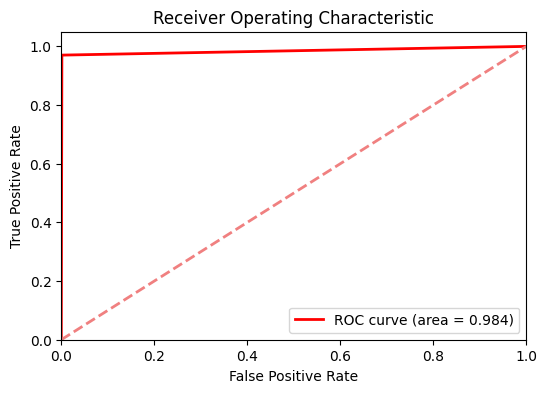

In [47]:
# After evaluating on the validation set, we evaluate and finalize on the test set

ml.evaluate_model_metrics(random_forest_grid, X_train, y_train, X_test, y_test, verbose=6)

## Cross Validation

### K-fold

In [48]:
ml.k_cross_validate(RandomForestClassifier(),X_train, y_train,cv=10,scoring='accuracy')


accuracy scores: [0.93117978 0.92837079 0.93539326 0.94382022 0.93811533 0.92967651
 0.93108298 0.9395218  0.94233474 0.94796062]

Mean accuracy score:  0.9367456028066183

Standard deviation:  0.006337435452275666


In [49]:
ml.k_cross_validate(RandomForestClassifier(**grid_best_params),X_train, y_train,cv=10,scoring='accuracy')


accuracy scores: [0.93539326 0.93117978 0.93679775 0.94382022 0.93811533 0.9254571
 0.93530239 0.94514768 0.94233474 0.95077356]

Mean accuracy score:  0.9384321812923719

Standard deviation:  0.006960035383201773


In [50]:
ml.k_cross_validate(RandomForestClassifier(**rand_best_params),X_train, y_train,cv=10,scoring='accuracy')


accuracy scores: [0.93539326 0.93117978 0.93679775 0.94382022 0.93811533 0.9254571
 0.93530239 0.94514768 0.94233474 0.95077356]

Mean accuracy score:  0.9384321812923719

Standard deviation:  0.006960035383201773


In [51]:
ml.k_cross_validate(RandomForestClassifier(**best_trial),X_train, y_train,cv=10,scoring='accuracy')


accuracy scores: [0.92837079 0.93117978 0.93679775 0.94662921 0.94233474 0.92264416
 0.93108298 0.94655415 0.94514768 0.95077356]

Mean accuracy score:  0.9381514799538552

Standard deviation:  0.008970952544538514


### Stratified K-fold

In [52]:
ml.stratified_k_cross_validate(RandomForestClassifier(),X_train, y_train,n_splits=10)


Average Accuracy: 0.937309375938305

Average Precision: 0.8471338710677443

Average Recall: 0.6514254385964913

Average F1-Score: 0.7355492465828292


In [53]:
ml.stratified_k_cross_validate(RandomForestClassifier(**grid_best_params),X_train, y_train,n_splits=10)


Average Accuracy: 0.9367463929581694

Average Precision: 0.848335484230654

Average Recall: 0.6451206140350877

Average F1-Score: 0.7313485558591795


In [54]:
ml.stratified_k_cross_validate(RandomForestClassifier(**rand_best_params),X_train, y_train,n_splits=10)


Average Accuracy: 0.9367463929581694

Average Precision: 0.848335484230654

Average Recall: 0.6451206140350877

Average F1-Score: 0.7313485558591795


In [55]:
ml.stratified_k_cross_validate(RandomForestClassifier(**best_trial),X_train, y_train,n_splits=10)


Average Accuracy: 0.9373097710140804

Average Precision: 0.8515323124181815

Average Recall: 0.6472368421052631

Average F1-Score: 0.734235513972468


### Save Model

In [56]:
# Saving the model

final_random_forest_estimator = RandomForestClassifier()
final_random_forest_estimator.fit(X_train, y_train)

ml.save_model(final_random_forest_estimator, "../Models/Diabetes/Random_Forest_Classifier.pkl")

Overwrite File? [y/n]: y
Saved Model


## Prediction

In [57]:
# Predicting on perturbed values

ml.predict_on_modified_instance(final_random_forest_estimator, X_test.iloc[0], y_test.iloc[0], 0.4)

Instance:
 [ 2.68142699e-01  2.60326648e-02  1.68064713e+00  1.75310108e-02
  1.69997872e+00 -4.30840325e-01 -3.03342180e-01 -1.77960097e-01
 -3.10098435e-01  4.78397640e-01  1.64290994e-01 -6.36669486e-01
 -6.90673158e-01  1.60043469e+00 -1.67535574e-01 -1.28044271e+00
 -8.06526079e-01  3.59577710e-02 -9.53750190e-01 -1.33309802e+00
  7.22003473e-03 -4.19539825e-01 -1.47377746e+00  3.97617450e-01
  7.15967664e-01 -1.00683899e-01 -3.79027598e-01  3.17537835e-01
  8.96465437e-01  2.96939068e+00 -2.52156486e-01  2.68377034e-16
 -4.68241370e-01 -1.02889488e+00  3.50628060e-01 -3.93322960e-01
  1.47173106e-01 -7.53857531e-02]

Expected Class:  0.0

 Modified Instance:
 [ 0.2681427   0.12820428  1.49245905 -0.1979693   1.56821068 -0.31114025
  0.02466144  0.04843222 -0.14248301  0.37457355  0.01169886 -0.62216126
 -0.77146489  1.66101628 -0.1547282  -1.43037757 -0.79137127  0.05458317
 -0.97022429 -1.03885733 -0.14552335 -0.52425735 -1.6031077   0.51272317
  0.62044856 -0.01636581 -0.285835

In [58]:
ml.predict_on_modified_instance(final_random_forest_estimator, X_test.iloc[20], y_test.iloc[20], 0.3)

Instance:
 [ 4.4391349   3.1584797   1.48088432  0.58176576  3.52676398 -0.16061106
 -0.30334218  2.34525669 -1.5725525   1.48958041  1.93148924  0.61406762
 -0.41794453 -0.23677412  0.46330594 -1.39094251 -0.47136039 -1.31133936
 -0.71383313 -0.45486527 -0.13923362 -0.50970178 -1.16994138  1.07598633
 -0.69665802  0.28878344  0.52524424 -0.0100781  -0.45813546  0.18967761
 -0.13122425 -1.02062553 -1.73725753 -0.30613754  0.50241834  0.67086254
 -0.44082716 -0.18995156]

Expected Class:  1.0

 Modified Instance:
 [ 4.43913490e+00  3.15267615e+00  1.54416094e+00  3.27966296e-01
  3.73713486e+00 -1.91317912e-01 -2.70007421e-01  2.36123027e+00
 -1.65225184e+00  1.06334537e+00  1.92609537e+00  5.59435377e-01
 -5.59827426e-01 -1.39217757e-01  5.75828527e-01 -1.73664955e+00
 -7.60660510e-03 -1.34077462e+00 -8.64830908e-01 -4.40632787e-01
  3.41768709e-03 -5.44494375e-01 -1.16778364e+00  1.22515513e+00
 -8.94515175e-01  2.69127595e-01  5.81082739e-01 -1.85755534e-01
 -7.52631444e-01  9.045647